# Intro 
I'm running a Linear Regression on credit card data using PySpark. The objective is to create a regression that predicts credit card debt using several descriptive features. In a previous notebook I explored the dataset and reduced the features down to the few I wanted to test. The dataset itself is only 5000 rows but in the case that the dataset were too large to run on a single machine the data would need to be processed across several machines. Therefore I handle the feature transformations and regressions with PySpark as if this were the case.

## Set Up

In [ ]:
# importing packages
import findspark
findspark.init()
import pyspark
import pyspark.sql.functions as F
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder, CrossValidator
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import OneHotEncoder, VectorAssembler, StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.types import StringType, DoubleType

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Use this to change pandas row settings. Good for when I need to see entire dataset
# pd.set_option("display.max_rows", None)
pd.set_option('display.max_rows', 100)

In [3]:
# Selected features from earlier data exploration
columns = ['inccat', 'carcatvalue', 'default', 'empcat', 'agecat', 'cardtenurecat', 'card2tenurecat', 'retire', 'carown', 'jobsat', 'creddebt', 'income', 'othdebt', 'carvalue', 'debtinc', 'cardspent', 'card2spent', 'employ', 'tollten', 'wireten', 'cardtenure']

Below I inital Spark, import the data into the spark session and create a temporary view so that I can also query the data with SQL.

In [4]:
sc = pyspark.SparkContext()
# sc.stop()

In [5]:
spark = pyspark.sql.SparkSession(sc)

data = spark.read.csv('credit_card_regression_set.csv', header = True, inferSchema = True)

data.createOrReplaceTempView('data')

These are the variables decided during my initial exploration of the 130 features.

In [6]:
y = 'creddebt'

nums = ['income',
 'othdebt',
 'carvalue',
 'debtinc',
 'cardspent',
 'card2spent',
 'employ',
 'tollten',
 'wireten',
 'cardtenure']

cats = ['inccat',
 'carcatvalue',
 'default',
 'empcat',
 'agecat',
 'cardtenurecat',
 'card2tenurecat',
 'retire',
 'carown',
 'jobsat']

binary = ['default', 'retire']

# Feature Engineering

Before I run the model I need to perform transformations that prepare the data for modeling. In this case It is mainly handling null values.

In [7]:
spark.sql("""SELECT inccat, carcatvalue,default, empcat, agecat, cardtenurecat, card2tenurecat, retire,carown, jobsat FROM data""" ).show()

+------+-----------+-------+------+------+-------------+--------------+------+------+------+
|inccat|carcatvalue|default|empcat|agecat|cardtenurecat|card2tenurecat|retire|carown|jobsat|
+------+-----------+-------+------+------+-------------+--------------+------+------+------+
|   2.0|        1.0|    1.0|   1.0|   2.0|          2.0|           2.0|   0.0|   1.0|   1.0|
|   1.0|        1.0|    1.0|   1.0|   2.0|          2.0|           2.0|   0.0|   1.0|   1.0|
|   2.0|        1.0|    0.0|   5.0|   6.0|          5.0|           5.0|   0.0|   1.0|   4.0|
|   1.0|        1.0|    1.0|   1.0|   2.0|          2.0|           2.0|   0.0|   1.0|   2.0|
|   1.0|        1.0|    0.0|   1.0|   3.0|          3.0|           3.0|   0.0|   0.0|   1.0|
|   4.0|       -1.0|    0.0|   5.0|   5.0|          5.0|           3.0|   0.0|  -1.0|   2.0|
|   4.0|        2.0|    0.0|   3.0|   5.0|          2.0|           2.0|   0.0|   1.0|   2.0|
|   4.0|        3.0|    0.0|   4.0|   4.0|          5.0|           5.0

The categorical variables have null values listed as '-1.0'. These null values need to be handled in order for the regression to run correctly. In this case I decided to handle them to reassigning them to the most frequent value. The code below iterates through the categorical columns, queries the column for the most frequent value and replaces all null cases with that value.

In [8]:
for column in cats:
#     column = 'carcatvalue'
    data = data.withColumn(column, data[column].cast(StringType()))
    query = """SELECT {0}, COUNT({0}) as count FROM data GROUP BY {0} ORDER BY count DESC LIMIT 1 """.format(column)
    frequent = str(spark.sql(query).first()[0])
    data = data.withColumn(column, F.regexp_replace(column, '-1.0', frequent))

data.select(cats).show()

+------+-----------+-------+------+------+-------------+--------------+------+------+------+
|inccat|carcatvalue|default|empcat|agecat|cardtenurecat|card2tenurecat|retire|carown|jobsat|
+------+-----------+-------+------+------+-------------+--------------+------+------+------+
|   2.0|        1.0|    1.0|   1.0|   2.0|          2.0|           2.0|   0.0|   1.0|   1.0|
|   1.0|        1.0|    1.0|   1.0|   2.0|          2.0|           2.0|   0.0|   1.0|   1.0|
|   2.0|        1.0|    0.0|   5.0|   6.0|          5.0|           5.0|   0.0|   1.0|   4.0|
|   1.0|        1.0|    1.0|   1.0|   2.0|          2.0|           2.0|   0.0|   1.0|   2.0|
|   1.0|        1.0|    0.0|   1.0|   3.0|          3.0|           3.0|   0.0|   0.0|   1.0|
|   4.0|        1.0|    0.0|   5.0|   5.0|          5.0|           3.0|   0.0|   1.0|   2.0|
|   4.0|        2.0|    0.0|   3.0|   5.0|          2.0|           2.0|   0.0|   1.0|   2.0|
|   4.0|        3.0|    0.0|   4.0|   4.0|          5.0|           5.0

The numerical columns have a similar issue. Null values are listed as '-1.0'. I'll use similar code except I will use the mean rather than the mode in the case of numeric features. 

In [9]:
for column in nums:
    data = data.withColumn(column, data[column].cast(StringType()))
    query = """SELECT MEAN({0}) FROM data""".format(column)
    mean = str(spark.sql(query).first()[0])
    data = data.withColumn(column, data[column].cast(StringType()))
    data = data.withColumn(column, F.regexp_replace(column, '-1.0', mean))
    data = data.withColumn(column, data[column].cast(DoubleType()))

data.select(nums).show()

+------+-------+------------------+-------+---------+----------+------+-------+-------+----------+
|income|othdebt|          carvalue|debtinc|cardspent|card2spent|employ|tollten|wireten|cardtenure|
+------+-------+------------------+-------+---------+----------+------+-------+-------+----------+
|  31.0|   2.24|              14.3|   11.1|    81.66|      67.8|   0.0| 161.05|    0.0|       2.0|
|  15.0|   1.57|               6.8|   18.6|     42.6|     34.94|   0.0|    0.0|1683.55|       4.0|
|  35.0|   2.54|              18.8|    9.9|   184.22|    175.75|  16.0|    0.0|    0.0|      35.0|
|  20.0|   1.12|               8.7|    5.7|   340.99|     18.42|   0.0|    0.0|    0.0|       5.0|
|  23.0|   0.18|              10.6|    1.7|    255.1|    252.73|   1.0|  387.7|  410.8|       8.0|
| 107.0|   4.93|23.232580000000013|    5.6|   228.27|       0.0|  22.0|  726.6|    0.0|      18.0|
|  77.0|   0.96|              25.6|    1.9|   822.32|    130.14|  10.0|    0.0|    0.0|       3.0|
|  97.0|  

In [11]:
data_train, data_test = data.randomSplit([.80, .20], seed = 4)

# Creating the Pipeline

With the data clean enough for modeling I need to create a pipeline that runs the regression. Techincally this process includes additional feature engineering as the categorical variables need to be indexed and one hot encoded. Finally, all of the features need to be assembled into a single vector that PySpark is capable of reading.

In [10]:
# Index and encoding objects
index_list = [cat +'_idx' for cat in cats]
string_index = StringIndexer(inputCols = cats, outputCols = index_list)

encoded_list = [cat + '_encoded' for cat in cats]
one_h_encode = OneHotEncoder(inputCols = index_list, outputCols = encoded_list)

In [12]:
# This code block allows me to decide features. I comment the extend methods that I wish to exclude when running the model
inputs = []
inputs.extend(nums)
inputs.extend(encoded_list)
inputs

['income',
 'othdebt',
 'carvalue',
 'debtinc',
 'cardspent',
 'card2spent',
 'employ',
 'tollten',
 'wireten',
 'cardtenure',
 'inccat_encoded',
 'carcatvalue_encoded',
 'default_encoded',
 'empcat_encoded',
 'agecat_encoded',
 'cardtenurecat_encoded',
 'card2tenurecat_encoded',
 'retire_encoded',
 'carown_encoded',
 'jobsat_encoded']

In [24]:
# This code creates the assembler and regression objects.

assembler = VectorAssembler(inputCols = inputs, outputCol = 'features')

regression = LinearRegression(labelCol='creddebt')

# pipeline object contains previously created objects
pipepline = Pipeline(stages = [string_index, one_h_encode, assembler, regression])

# model object fits the pipeline to the training data. predictions 
model = pipepline.fit(data_train)

predictions = model.transform(data_test)

## Evaluation

The table below shows the model predictions compared to the actual credit debt. 'Creddebt' is listed in the thousands. Therefore in the case of the first observation, the model predicted that this observation with an actual debt of 140 dollars would actually be about 600 dollars in debt.

In [25]:
predictions.select(['creddebt','prediction']).show()

+--------+--------------------+
|creddebt|          prediction|
+--------+--------------------+
|    0.14|  0.6093043679675625|
|    0.24| 0.43905437552333204|
|    0.52|0.012254495737605176|
|    0.39|   1.507075165380026|
|    1.13|   3.206200072134242|
|    0.02| -0.7176964758160933|
|    0.45|  0.8612760486636706|
|    2.46|  2.5064292029472672|
|    6.61|   4.050840955195323|
|   44.25|   13.44364556197883|
|    0.15| -0.5992770881744303|
|    8.15|    5.87001498551057|
|    0.39|-0.26548513694924303|
|    0.78|  1.7494149226058622|
|    0.34| -0.4892234737470511|
|   29.47|   9.280357979257039|
|    0.11| 0.22478571931758262|
|    4.73|   6.389449128368286|
|    0.78|  1.3024720830240581|
|    1.77|   1.021364413293012|
+--------+--------------------+
only showing top 20 rows



In [26]:
# Evaluation checks the total error of the model based on an evaluation metric in this case the metric is  root mean squared error
evaluation = RegressionEvaluator(metricName = 'rmse', labelCol='creddebt').evaluate(predictions)

evaluation

2.2154065173974407

# Documentation 
I created a dataframe and a function to add the results of each prediction to my model to document the models improvement as I change parameters and features.

In [18]:
metrics = pd.DataFrame({'model': [], 'rmse':[], 'mse' : []})
# metrics.to_csv('metrics.csv')
# metrics = pd.read_csv('metrics.csv')
# metrics = metrics.iloc[:,1:]

In [19]:
# These functions evaluate the rmse and mse of the column and add them to my metrics dataframe.
def add_row(df, row):
    df.loc[len(df)] = row

def add_model_metrics(df, model_name, predictions):
    rmse = RegressionEvaluator(metricName = 'rmse', labelCol='creddebt').evaluate(predictions)
    mse = RegressionEvaluator(metricName = 'mse', labelCol='creddebt').evaluate(predictions)
    
    row = [model_name, rmse, mse]
    
    add_row(df, row)

In [ ]:
# add_model_metrics(metrics, 'nums_and_cats', predictions)

These are the first two models I ran one with only the numerical variables and a second with both the numerical and categorical variables. The first model has a rmse of 2.275 which suggests that the model is off by about 2270 dollars on average. With the categorical variables, the model is 60 dollars more effective on average when predicted on the test data. 

In [28]:
metrics

,model,rmse,mse
0,num_only,2.275009,5.175667
1,nums_and_cats,2.215407,4.908026


# Additional Features

## Cross Validation
Adding cross validation (5 fold) to potentially increase model performance. Code below is similar to previous pipeline code with some additions for cross validation.

In [29]:
index_list = [cat +'_idx' for cat in cats]
string_index = StringIndexer(inputCols = cats, outputCols = index_list)

encoded_list = [cat + '_encoded' for cat in cats]

one_h_encode = OneHotEncoder(inputCols = index_list, outputCols = encoded_list)

assembler = VectorAssembler(inputCols = inputs, outputCol = 'features')

regression = LinearRegression(labelCol='creddebt')

pipeline = Pipeline(stages = [string_index, one_h_encode, assembler, regression])

evaluator = RegressionEvaluator(metricName = 'rmse', labelCol='creddebt')

paramGrid = ParamGridBuilder().build()

cvModel = CrossValidator(estimator = pipeline, evaluator = evaluator, numFolds = 4, estimatorParamMaps = paramGrid)

cvModel = CrossValidator.fit(cvModel, data_train)

predictions = cvModel.transform(data_test)

In [30]:
add_model_metrics(metrics, 'all_vars_cv_1', predictions)
metrics

,model,rmse,mse
0,num_only,2.275009,5.175667
1,nums_and_cats,2.215407,4.908026
2,all_vars_cv_1,2.215407,4.908026


It appears that cross validation had no effect on the model performance.

## Log Transformation

There are a few feature adjustments that I could potentially improve the model. First, some of the continuous variables aren't normally distributed. Applying a log transformation to some of the continuous variables notably changed the distribution to be more normal. 

In [91]:
to_be_logged = ['income',
 'othdebt',
 'carvalue',
 'cardspent',
 'card2spent',
 'employ',
 'tollten',
 'wireten']

reg_nums = ['debtinc',
 'cardtenure']

log_nums = ['log_' + column for column in to_be_logged]

In [44]:
# This code goes through the to_be_logged list and applies the log transformation.
from pyspark.sql.functions import log
for column in to_be_logged:
    data = data.withColumn('log_' + column, log(data[column] + 1))

In [45]:
# Have to reinitialize training data to include new log values.
data_train, data_test = data.randomSplit([.80, .20], seed = 4)

In [77]:
# Ran this three times once with only continuous and a second time with categorical variables third time with both log and continuous
inputs = []
inputs.extend(log_nums)
inputs.extend(reg_nums)
index_list = [cat +'_idx' for cat in cats]
inputs.extend(index_list)
inputs.extend(to_be_logged)


string_index = StringIndexer(inputCols = cats, outputCols = index_list)

encoded_list = [cat + '_encoded' for cat in cats]

one_h_encode = OneHotEncoder(inputCols = index_list, outputCols = encoded_list)

assembler = VectorAssembler(inputCols = inputs, outputCol = 'features')

regression = LinearRegression(labelCol='creddebt')

pipeline = Pipeline(stages = [string_index, one_h_encode, assembler, regression])

evaluator = RegressionEvaluator(metricName = 'rmse', labelCol='creddebt')

paramGrid = ParamGridBuilder().build()

cvModel = CrossValidator(estimator = pipeline, evaluator = evaluator, numFolds = 4, estimatorParamMaps = paramGrid)

cvModel = CrossValidator.fit(cvModel, data_train)

predictions = cvModel.transform(data_test)

In [47]:
# log only
predictions.select(['creddebt','prediction']).show()

+--------+--------------------+
|creddebt|          prediction|
+--------+--------------------+
|    0.14|   1.647075423659162|
|    0.24|  0.6398959925978822|
|    0.52|  1.0997906096953702|
|    0.39|  0.3504364866826766|
|    1.13|  2.9820424472769513|
|    0.02| -1.9022647714346022|
|    0.45|  0.7227840152447431|
|    2.46|  3.6401236181581247|
|    6.61|   4.143968229124148|
|   44.25|   9.636200858653792|
|    0.15|   -1.18055814271729|
|    8.15|   7.317615336208826|
|    0.39| -0.4845952073333475|
|    0.78|  1.3886183932839593|
|    0.34|  -0.342778877833398|
|   29.47|   8.245049772042242|
|    0.11|-0.11961579436530378|
|    4.73|   4.785692639501264|
|    0.78|-0.01416733325522...|
|    1.77|   1.573471743150824|
+--------+--------------------+
only showing top 20 rows



In [75]:
# logs_and_cats
predictions.select(['creddebt','prediction']).show()

+--------+-------------------+
|creddebt|         prediction|
+--------+-------------------+
|    0.14| 1.2884720002611854|
|    0.24|-0.1333820961933423|
|    0.52| 0.6504041999093033|
|    0.39| 1.1970963328240192|
|    1.13| 2.7496023407588517|
|    0.02|-1.4263460324400405|
|    0.45|  -0.19447120947091|
|    2.46|  3.573529458318564|
|    6.61|   5.61117129623733|
|   44.25| 10.727084238308777|
|    0.15|-2.0566687769911294|
|    8.15|  7.613715198840104|
|    0.39|-1.2405597564490094|
|    0.78| 2.6866694377778852|
|    0.34| -1.012504694987344|
|   29.47|  9.559866729767748|
|    0.11|-0.5206746091395491|
|    4.73| 5.0217777453217884|
|    0.78| 0.7543957441303526|
|    1.77|   0.81080977472668|
+--------+-------------------+
only showing top 20 rows



In [78]:
# nums_logs_and_cats
predictions.select(['creddebt','prediction']).show()

+--------+-------------------+
|creddebt|         prediction|
+--------+-------------------+
|    0.14|0.49792826424154235|
|    0.24|0.41489351806923125|
|    0.52| 1.1100405323315137|
|    0.39| 1.0485681882122222|
|    1.13| 1.8889272517262299|
|    0.02|-0.6776597182744579|
|    0.45|0.48076946156178746|
|    2.46| 3.4513634556554464|
|    6.61|  4.029615100979548|
|   44.25| 14.408801210838694|
|    0.15|-0.8155181450877169|
|    8.15|  7.228276573264578|
|    0.39|-0.1515153538643217|
|    0.78| 0.9778442365562707|
|    0.34|0.41171528082751685|
|   29.47| 10.902899075433812|
|    0.11|-0.5355067880359905|
|    4.73|  5.778526907345183|
|    0.78|  1.628078117979622|
|    1.77| 1.4989848161401254|
+--------+-------------------+
only showing top 20 rows



In [79]:
add_model_metrics(metrics, 'nums_logs_and_cats', predictions)
metrics

,model,rmse,mse
0,num_only,2.275009,5.175667
1,nums_and_cats,2.215407,4.908026
2,all_vars_cv_1,2.215407,4.908026
3,num_only_log,2.335687,5.455432
4,logs_and_cats,2.252368,5.073160
5,nums_logs_and_cats,2.085990,4.351353


Running all of the continous, log adjusted variables, and categorical variables together seems to have gained the best overall performance.

## Regularization

The last thing I will try is a grid search with some hyperparameter adjustments. This will include the regularization weight along with the elastic net which balances between the l1 and l2 regularization types. I will add the best iteration to my metrics dataframe.

In [80]:
index_list = [cat +'_idx' for cat in cats]
string_index = StringIndexer(inputCols = cats, outputCols = index_list)

encoded_list = [cat + '_encoded' for cat in cats]

one_h_encode = OneHotEncoder(inputCols = index_list, outputCols = encoded_list)

assembler = VectorAssembler(inputCols = inputs, outputCol = 'features')

regression = LinearRegression(labelCol='creddebt')

pipeline = Pipeline(stages = [string_index, one_h_encode, assembler, regression])

evaluator = RegressionEvaluator(metricName = 'rmse', labelCol='creddebt')

paramGrid = ParamGridBuilder().addGrid(regression.regParam, [0.1, 0.01, .001]).addGrid(regression.fitIntercept, [True])
paramGrid = paramGrid.addGrid(regression.elasticNetParam, [0.0, 0.5, 1.0]).build()

cvModel = CrossValidator(estimator = pipeline, evaluator = evaluator, numFolds = 4, estimatorParamMaps = paramGrid)

cvModel = CrossValidator.fit(cvModel, data_train)

predictions = cvModel.transform(data_test)

In [81]:
add_model_metrics(metrics, 'original_logs_cats_hyper_tuned', predictions)
metrics

,model,rmse,mse
0,num_only,2.275009,5.175667
1,nums_and_cats,2.215407,4.908026
2,all_vars_cv_1,2.215407,4.908026
3,num_only_log,2.335687,5.455432
4,logs_and_cats,2.252368,5.073160
5,nums_logs_and_cats,2.085990,4.351353
6,original_logs_cats_hyper_tuned,2.101103,4.414633


In [82]:
print('Best Regularization Parameter: ', cvModel.bestModel.stages[-1]._java_obj.parent().getRegParam())
print('Best ElasticNet Parameter: ',cvModel.bestModel.stages[-1]._java_obj.parent().getElasticNetParam())


Best Regularization Parameter:  0.1
Best ElasticNet Parameter:  0.0


The model chosen was a ridge regression with a strength of .1. Although it performs worse than the previous model it is likely that the ridge regression is more generalizable. I'll stick with this as the final model when interpreting variables.

# Best Model Interpretation

In order to interpret the model I will run a final regression in pandas using the determined parameters. This will allow me to visualize and interpret the coefficients at a more individual level.

In [123]:
pd_data_train = data_train.toPandas()
pd_data_test = data_test.toPandas()

In [124]:
inputs = []
inputs.extend(log_nums)
inputs.extend(reg_nums)
inputs.extend(cats)
inputs.extend(to_be_logged)
inputs.append('creddebt')
inputs = set(inputs)

pd_data_train = pd_data_train[inputs]
pd_data_test = pd_data_test[inputs]

In [125]:
pd_data_train = pd.get_dummies(pd_data_train)
X_train = pd_data_train.drop('creddebt', axis = 1)
y_train = pd_data_train['creddebt']
pd_data_test = pd.get_dummies(pd_data_test)
X_test = pd_data_test.drop('creddebt', axis = 1)
y_test = pd_data_test['creddebt']

In [126]:
pd_data_train

,debtinc,card2spent,income,log_card2spent,log_income,cardtenure,wireten,carvalue,tollten,log_tollten,...,jobsat_1.0,jobsat_2.0,jobsat_3.0,jobsat_4.0,jobsat_5.0,empcat_1.0,empcat_2.0,empcat_3.0,empcat_4.0,empcat_5.0
0,2.0,114.70,85.0,4.751001,4.454347,15.0,621.90,43.10000,554.75,6.320319,...,0,0,0,1,0,0,0,0,1,0
1,13.1,66.60,39.0,4.213608,3.688879,31.0,0.00,10.00000,0.00,0.000000,...,0,0,0,1,0,0,0,0,1,0
2,6.2,394.15,138.0,5.979265,4.934474,1.0,30.05,66.20000,20.50,3.068053,...,0,0,0,1,0,0,1,0,0,0
3,25.1,197.63,63.0,5.291444,4.158883,17.0,0.00,39.30000,0.00,0.000000,...,1,0,0,0,0,0,0,1,0,0
4,9.2,214.91,37.0,5.374862,3.637586,19.0,0.00,15.80000,0.00,0.000000,...,1,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3982,5.9,839.40,84.0,6.733878,4.442651,15.0,887.50,30.60000,557.55,6.325344,...,0,1,0,0,0,0,0,1,0,0
3983,0.8,156.35,47.0,5.058473,3.871201,19.0,0.00,22.40000,0.00,0.000000,...,0,0,1,0,0,0,0,0,1,0
3984,1.3,84.25,31.0,4.445588,3.465736,9.0,0.00,17.10000,0.00,0.000000,...,0,1,0,0,0,0,1,0,0,0
3985,19.5,56.98,26.0,4.060098,3.295837,6.0,0.00,11.60000,0.00,0.000000,...,0,0,1,0,0,0,1,0,0,0


In [127]:
from sklearn.linear_model import ElasticNet
lr = ElasticNet(.1, 0)
lr.fit(X_train, y_train)

C:\Users\Allen\anaconda3\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass l1_ratio=0 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
C:\Users\Allen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8504.175821644329, tolerance: 4.811267459974919
  positive)


ElasticNet(alpha=0.1, l1_ratio=0)

In [128]:
predictions = lr.predict(X_test)

Below I create a dataframe with the coefficient data. I create a column 'sign' that is meant to record whether or not the variable is positive or negative. I also create a 'coefficient_abs' column which transforms the variable into its absolute value. These columns will be useful for visualizing and comparing all of the features based on their impact and usefulness to the model.

In [130]:
coefficient_data = pd.DataFrame({'feature' : X_train.columns, 'coefficient' : lr.coef_})

coefficient_data = coefficient_data.sort_values('coefficient', ascending = False)

coefficient_data['sign'] = coefficient_data['coefficient'].apply(lambda n: 'positive' if n > 0 else 'negative')

coefficient_data['coefficient_abs'] = coefficient_data['coefficient'].apply(lambda n: np.abs(n))

coefficient_data

,feature,coefficient,sign,coefficient_abs
34,default_1.0,0.362657,positive,0.362657
14,log_carvalue,0.204723,positive,0.204723
0,debtinc,0.202457,positive,0.202457
15,othdebt,0.126545,positive,0.126545
20,inccat_3.0,0.123089,positive,0.123089
19,inccat_2.0,0.094148,positive,0.094148
10,log_employ,0.083809,positive,0.083809
51,jobsat_5.0,0.076830,positive,0.076830
54,empcat_3.0,0.076712,positive,0.076712
30,agecat_6.0,0.067036,positive,0.067036


In [131]:
coefficient_data.describe()

,coefficient,coefficient_abs
count,57.000000,57.000000
mean,-0.016617,0.082216
std,0.188638,0.170250
min,-1.202853,0.000107
25%,-0.028574,0.016799
50%,0.000107,0.031053
75%,0.049407,0.076712
max,0.362657,1.202853


Looking at the coefficient data I decide that using the 75% marker on the magnitude makes the most sense and filter at coefficients that don't have a beta value larger than .07. I then visualize these 'impactful coefficients' below. 

In [141]:
impactful_coefs = coefficient_data[coefficient_data['coefficient_abs'] > .07]
non_impactful_coefs = coefficient_data[coefficient_data['coefficient_abs'] < .07]

In [142]:
impactful_coefs

,feature,coefficient,sign,coefficient_abs
34,default_1.0,0.362657,positive,0.362657
14,log_carvalue,0.204723,positive,0.204723
0,debtinc,0.202457,positive,0.202457
15,othdebt,0.126545,positive,0.126545
20,inccat_3.0,0.123089,positive,0.123089
19,inccat_2.0,0.094148,positive,0.094148
10,log_employ,0.083809,positive,0.083809
51,jobsat_5.0,0.076830,positive,0.076830
54,empcat_3.0,0.076712,positive,0.076712
23,carcatvalue_1.0,-0.088082,negative,0.088082


In [143]:
impactful_coefs = impactful_coefs.sort_values('coefficient_abs', ascending = False)

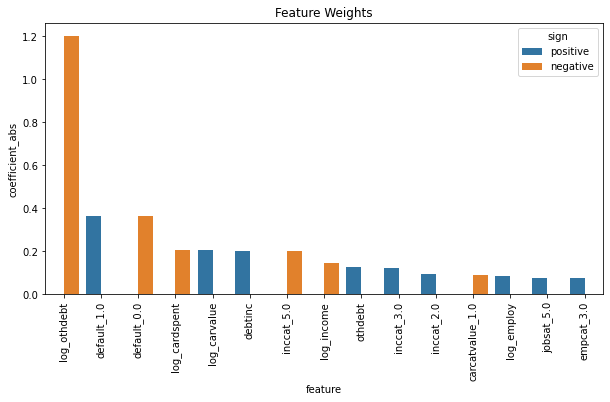

In [147]:
fig, ax = plt.subplots(figsize = (10,5))
plot = sns.barplot(data = impactful_coefs.head(15), x = 'feature', y = 'coefficient_abs', hue = 'sign', hue_order = ['positive', 'negative'])
plt.title('Feature Weights')
ticks = plot.set_xticklabels(plot.get_xticklabels(),rotation = 90)

In [145]:
non_impactful_coefs

,feature,coefficient,sign,coefficient_abs
30,agecat_6.0,0.067036,positive,0.067036
25,carcatvalue_3.0,0.062675,positive,0.062675
21,inccat_4.0,0.052980,positive,0.052980
45,card2tenurecat_4.0,0.049983,positive,0.049983
55,empcat_4.0,0.049716,positive,0.049716
2,income,0.049407,positive,0.049407
13,log_wireten,0.027120,positive,0.027120
50,jobsat_4.0,0.026380,positive,0.026380
24,carcatvalue_2.0,0.025407,positive,0.025407
37,cardtenurecat_1.0,0.018748,positive,0.018748


In [138]:
metrics

,model,rmse,mse
0,num_only,2.275009,5.175667
1,nums_and_cats,2.215407,4.908026
2,all_vars_cv_1,2.215407,4.908026
3,num_only_log,2.335687,5.455432
4,logs_and_cats,2.252368,5.073160
5,nums_logs_and_cats,2.085990,4.351353
6,original_logs_cats_hyper_tuned,2.101103,4.414633


In [139]:
sc.stop()
# metrics.to_csv('metrics.csv')

# Analysis and Conclusion

The model results mostly seem intuitive. Other debt, whether or not you've ever defaulted, and amount spent on card last month are sensible indicators for credit card debt. On the lower end, it seems to be interesting that variables related to employment and job security indicate more credit debt.

There's likely alot more hyper parameter tuning that can be done to develop a model with less error. Along with that features excluded in my analysis could be included and features determined to be useless could be excluded in a new model. A gradient boosting model could also be run with regression trees to see if they are generally more efffective.